<a href="https://colab.research.google.com/github/Tomawock/MLDM_COVID-19/blob/master/CorrelationResults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [66]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, max_error

In [9]:
os.chdir("/content/drive/Shared drives/MLDM progetto/Datasets/")

#Calcolo della previsioni dei nuovi positivi da parte degli extra trees

In [52]:
df_2 = pd.read_csv('dataset_finali/dataset_finale_medie_rnd220.csv', parse_dates=["Data"], infer_datetime_format=True)
rnd_state = 432145
feature = 'fut1_nuovi_positivi'

predictor_columns = [
            'pass_Ammoniaca', 
            'pass_Benzene',
            'pass_Biossido di Azoto', 
            'pass_Biossido di Zolfo',
            'pass_Monossido di Azoto', 
            'pass_Monossido di Carbonio',
            'pass_Ossidi di Azoto', 
            'pass_Ozono', 
            'pass_PM10 (SM2005)',
            'pass_Particelle sospese PM2.5',
            'pass_Radiazione Globale', 
            'pass_Temperatura',
            'pass_deceduti',
            'pass_nuovi_positivi',
            'pass_ricoverati_con_sintomi', 
            'pass_tamponi']

n_estimators_list = [100]
criterion_list = ["mse", "mae"]
max_depth_list = [None, 5, 6]
min_samples_split_list = [2, 3]
min_samples_split_leaf_list = [3,5]
min_weight_fraction_leaf_list = [0.0, 0.1]
max_features_list = ["auto", "sqrt", "log2"]
max_leaf_nodes_list = [None, 10, 25]
min_impurity_decrease_list = [0.0, 0.1]

param_grd = { "n_estimators":n_estimators_list,
                "criterion": criterion_list,
                "max_depth": max_depth_list,
                "min_samples_split": min_samples_split_list,
                "min_samples_leaf": min_samples_split_leaf_list,
                "min_weight_fraction_leaf": min_weight_fraction_leaf_list,
                "max_features": max_features_list,
                "max_leaf_nodes": max_leaf_nodes_list,
                "min_impurity_decrease": min_impurity_decrease_list}



################################################################################
train_2 = df_2.sample(frac=0.70, random_state=rnd_state)
test_2 = df_2.drop(train_2.index)

train_X_2 = train_2[predictor_columns]
train_y_2 = train_2[feature]

test_X_2 = test_2[predictor_columns]
test_y_2 = test_2[feature]
################################################################################
extra_tree_regressor = ExtraTreesRegressor(bootstrap=False,random_state=rnd_state) 
################################################################################
imp=SimpleImputer(missing_values=np.nan, strategy="mean")
imp=imp.fit(train_X_2)
################################################################################
grid_regressor_2 = GridSearchCV(extra_tree_regressor, param_grd, 
                            n_jobs=-1, 
                            verbose=0)
################################################################################
grid_regressor_2.fit(imp.transform(train_X_2), train_y_2)
################################################################################
best_regressor_2 = grid_regressor_2.best_estimator_

imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer = imputer.fit(test_X_2)
test_X_imp = imputer.transform(test_X_2)

predicted_positives = best_regressor_2.predict(test_X_imp)
predicted_positives

array([1728.91527608, 1823.276585  , 1806.74012667, 1819.53407218,
       1655.64722577, 1235.43038496, 1253.24934999, 1226.99510323,
       1226.82127656, 1176.24317461,  919.70386398, 1018.78264128,
        840.59873925,  795.64994664,  766.49225307,  745.61666992,
        675.29932056,  637.6510749 ,  568.90677034,  577.53539738,
        546.71583334,  433.09713536,  400.51824491,  302.1854989 ,
        254.44152846,  284.81366286,  240.24408484,  200.72393062,
        197.48290853,  197.56899258,  190.16428155,  196.49700599,
        205.76825293,   81.05943434,   81.96559179,   82.05904806,
         86.52008022,   71.58847971,   73.1736753 ,   72.68022769,
         75.97572372,   77.11193455,   75.75528662])

In [100]:
extimate_with_regression = ['fut1_ricoverati_con_sintomi',
                     'fut1_terapia_intensiva',
                     'fut1_deceduti',
                     'fut1_totale_ospedalizzati',
                     'fut1_dimessi_guariti']
models = {}
x = predicted_positives.reshape(-1, 1) 
for feature in extimate_with_regression:
  models[feature]=LinearRegression().fit(x, test_2[feature].values)
  print(f"R2 for {feature}\t\t\t{models[feature].score(x, test_2[feature].values)}")

R2 for fut1_ricoverati_con_sintomi			0.5371116743373269
R2 for fut1_terapia_intensiva			0.752113772816512
R2 for fut1_deceduti			0.8848261108453404
R2 for fut1_totale_ospedalizzati			0.5594583648754172
R2 for fut1_dimessi_guariti			0.8911617730306671


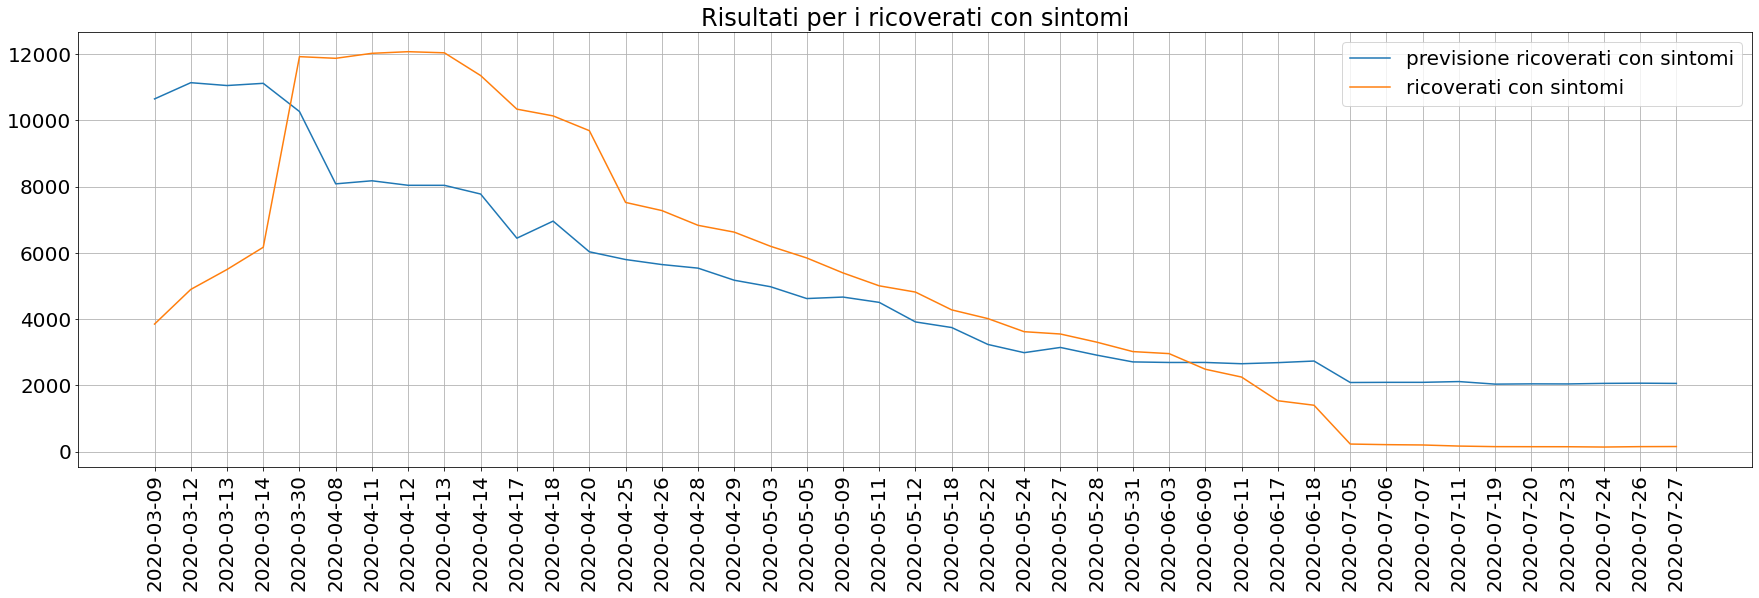




R2: 		0.537
RMSE: 		2.69e+03
MAX ERR: 	6798.575325734984


In [94]:
predicted=models[extimate_with_regression[0]].predict(x)
dataset_val=df_2.drop(train_2.index)[extimate_with_regression[0]].values


x_triks=df_2.loc[list(test_X_2.index),['Data']]
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (30, 8)
plt.plot(predicted, label="previsione ricoverati con sintomi")
plt.plot(dataset_val, label="ricoverati con sintomi")
plt.xticks(np.arange(x_triks.shape[0]), (x_triks['Data'].dt.date), rotation=90)
plt.legend()
plt.grid()
plt.title("Risultati per i ricoverati con sintomi")
plt.show()
print('\n\n')
print(f"R2: \t\t{r2_score(dataset_val, predicted):.3}")
print(f"RMSE: \t\t{mean_squared_error(dataset_val, predicted, squared=False):.3}")
print(f"MAX ERR: \t{max_error(dataset_val, predicted)}")

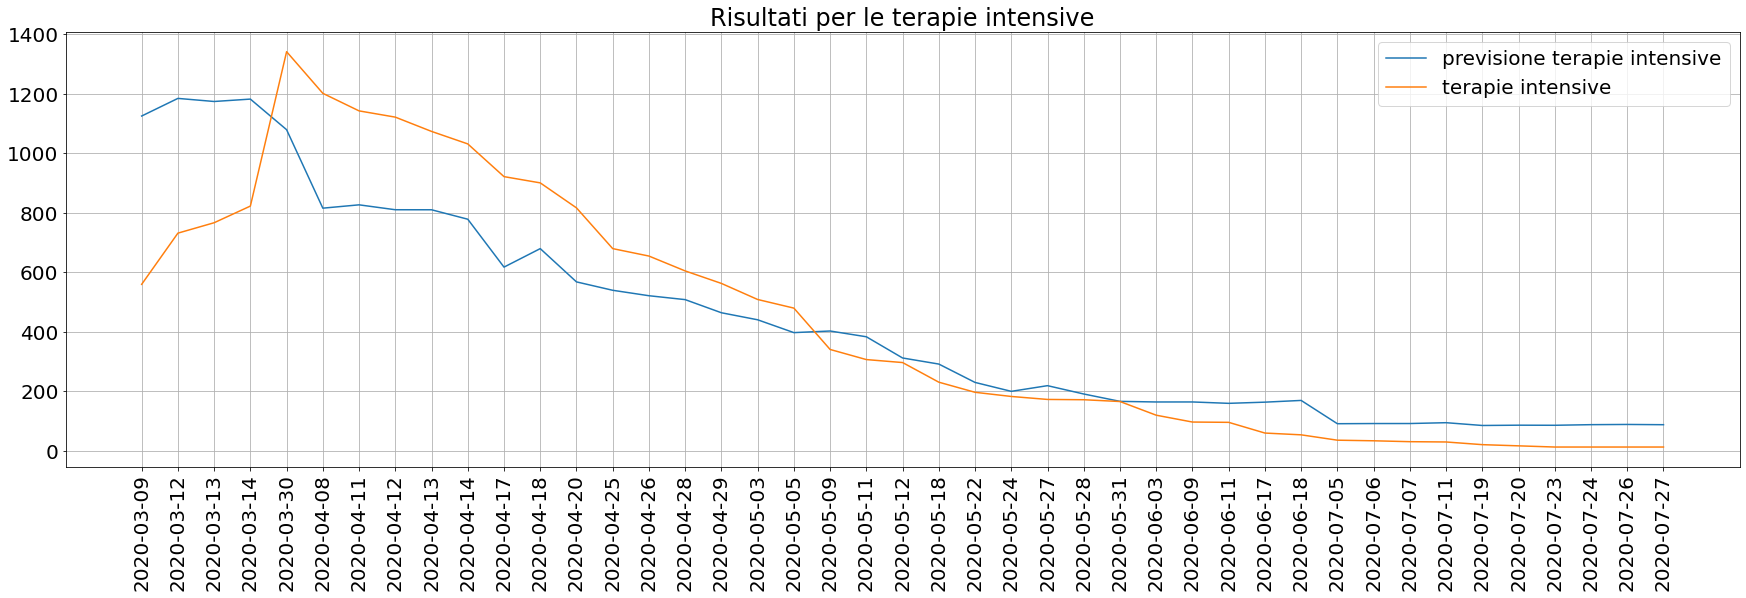




R2: 		0.752
RMSE: 		2.01e+02
MAX ERR: 	565.7434988136044


In [95]:
predicted=models[extimate_with_regression[1]].predict(x)
dataset_val=df_2.drop(train_2.index)[extimate_with_regression[1]].values


x_triks=df_2.loc[list(test_X_2.index),['Data']]
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (30, 8)
plt.plot(predicted, label="previsione terapie intensive")
plt.plot(dataset_val, label="terapie intensive")
plt.xticks(np.arange(x_triks.shape[0]), (x_triks['Data'].dt.date), rotation=90)
plt.legend()
plt.grid()
plt.title("Risultati per le terapie intensive")
plt.show()
print('\n\n')
print(f"R2: \t\t{r2_score(dataset_val, predicted):.3}")
print(f"RMSE: \t\t{mean_squared_error(dataset_val, predicted, squared=False):.3}")
print(f"MAX ERR: \t{max_error(dataset_val, predicted)}")

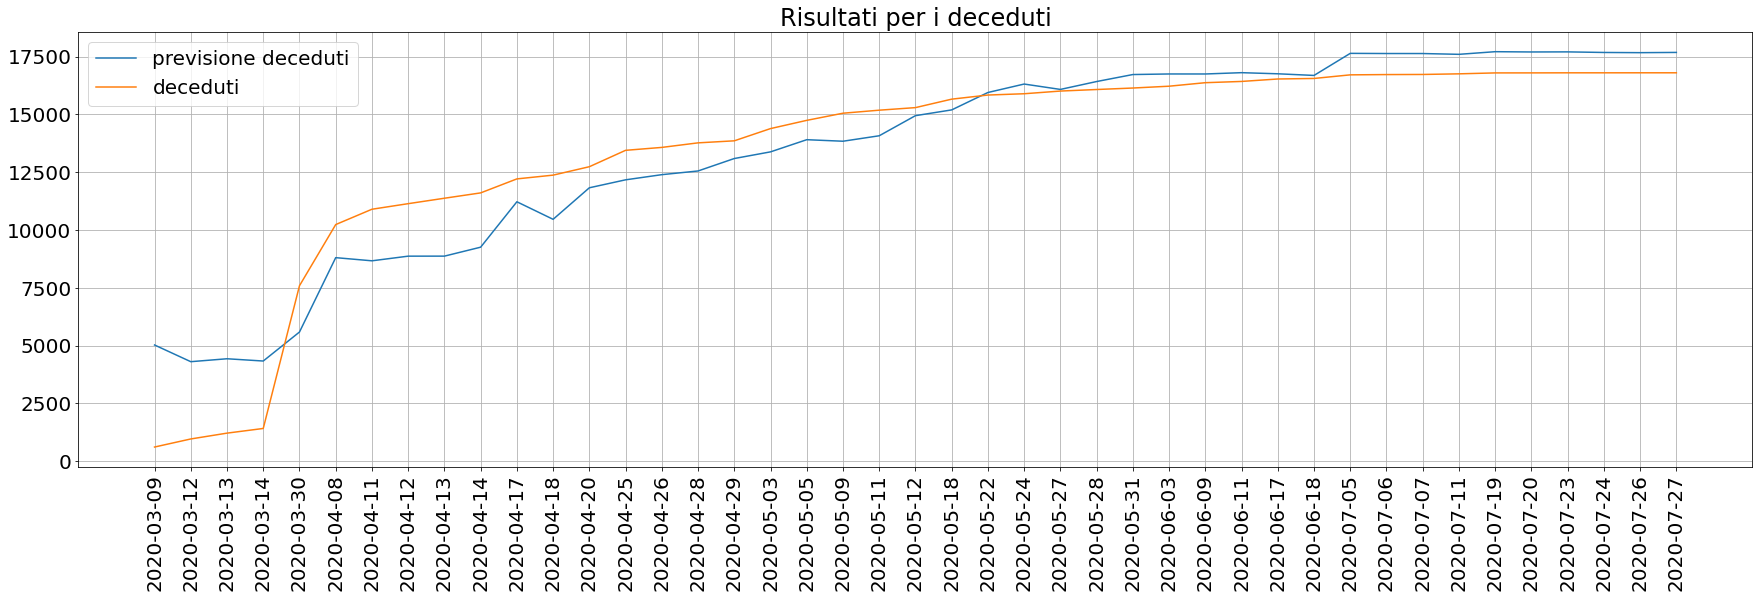




R2: 		0.885
RMSE: 		1.54e+03
MAX ERR: 	4413.23441189352


In [96]:
predicted=models[extimate_with_regression[2]].predict(x)
dataset_val=df_2.drop(train_2.index)[extimate_with_regression[2]].values


x_triks=df_2.loc[list(test_X_2.index),['Data']]
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (30, 8)
plt.plot(predicted, label="previsione deceduti")
plt.plot(dataset_val, label="deceduti")
plt.xticks(np.arange(x_triks.shape[0]), (x_triks['Data'].dt.date), rotation=90)
plt.legend()
plt.grid()
plt.title("Risultati per i deceduti")
plt.show()
print('\n\n')
print(f"R2: \t\t{r2_score(dataset_val, predicted):.3}")
print(f"RMSE: \t\t{mean_squared_error(dataset_val, predicted, squared=False):.3}")
print(f"MAX ERR: \t{max_error(dataset_val, predicted)}")

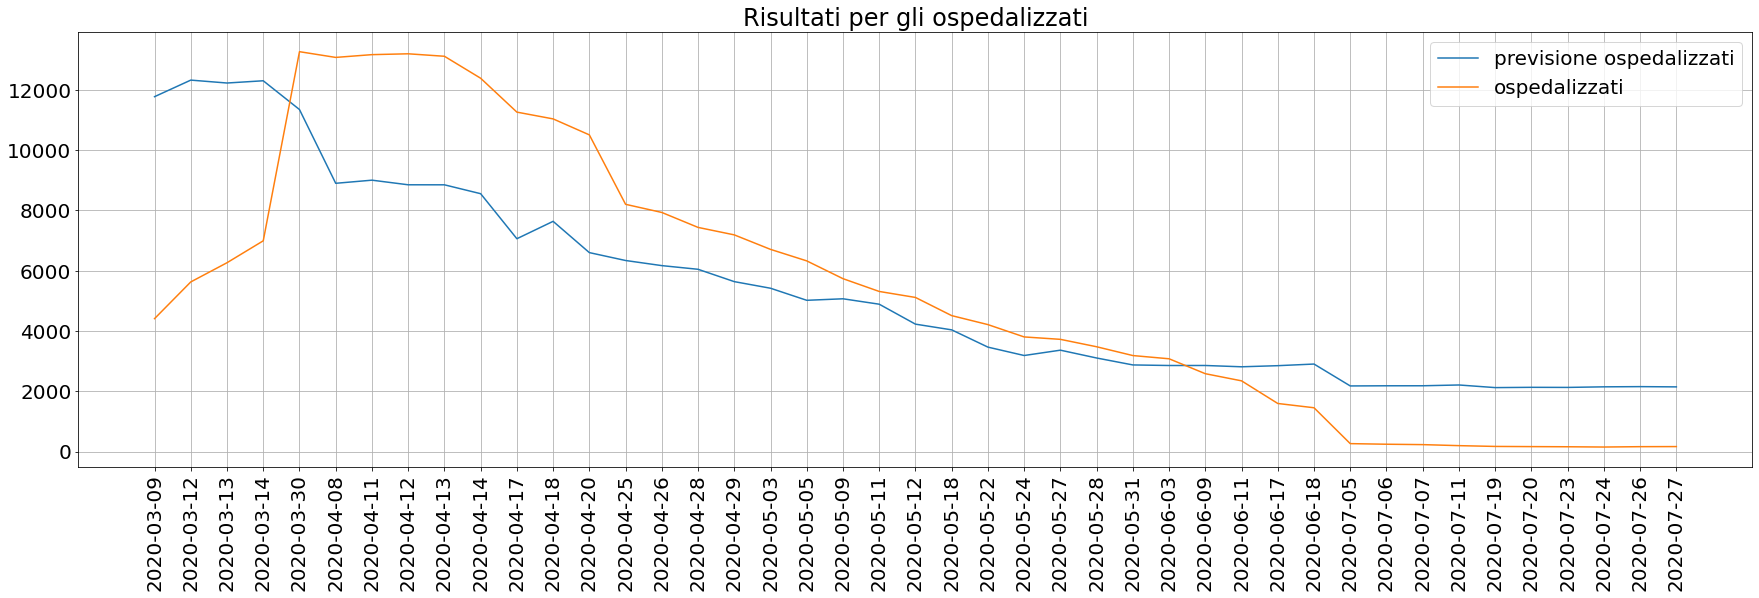




R2: 		0.559
RMSE: 		2.88e+03
MAX ERR: 	7364.318824548585


In [97]:
predicted=models[extimate_with_regression[3]].predict(x)
dataset_val=df_2.drop(train_2.index)[extimate_with_regression[3]].values


x_triks=df_2.loc[list(test_X_2.index),['Data']]
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (30, 8)
plt.plot(predicted, label="previsione ospedalizzati")
plt.plot(dataset_val, label="ospedalizzati")
plt.xticks(np.arange(x_triks.shape[0]), (x_triks['Data'].dt.date), rotation=90)
plt.legend()
plt.grid()
plt.title("Risultati per gli ospedalizzati")
plt.show()
print('\n\n')
print(f"R2: \t\t{r2_score(dataset_val, predicted):.3}")
print(f"RMSE: \t\t{mean_squared_error(dataset_val, predicted, squared=False):.3}")
print(f"MAX ERR: \t{max_error(dataset_val, predicted)}")

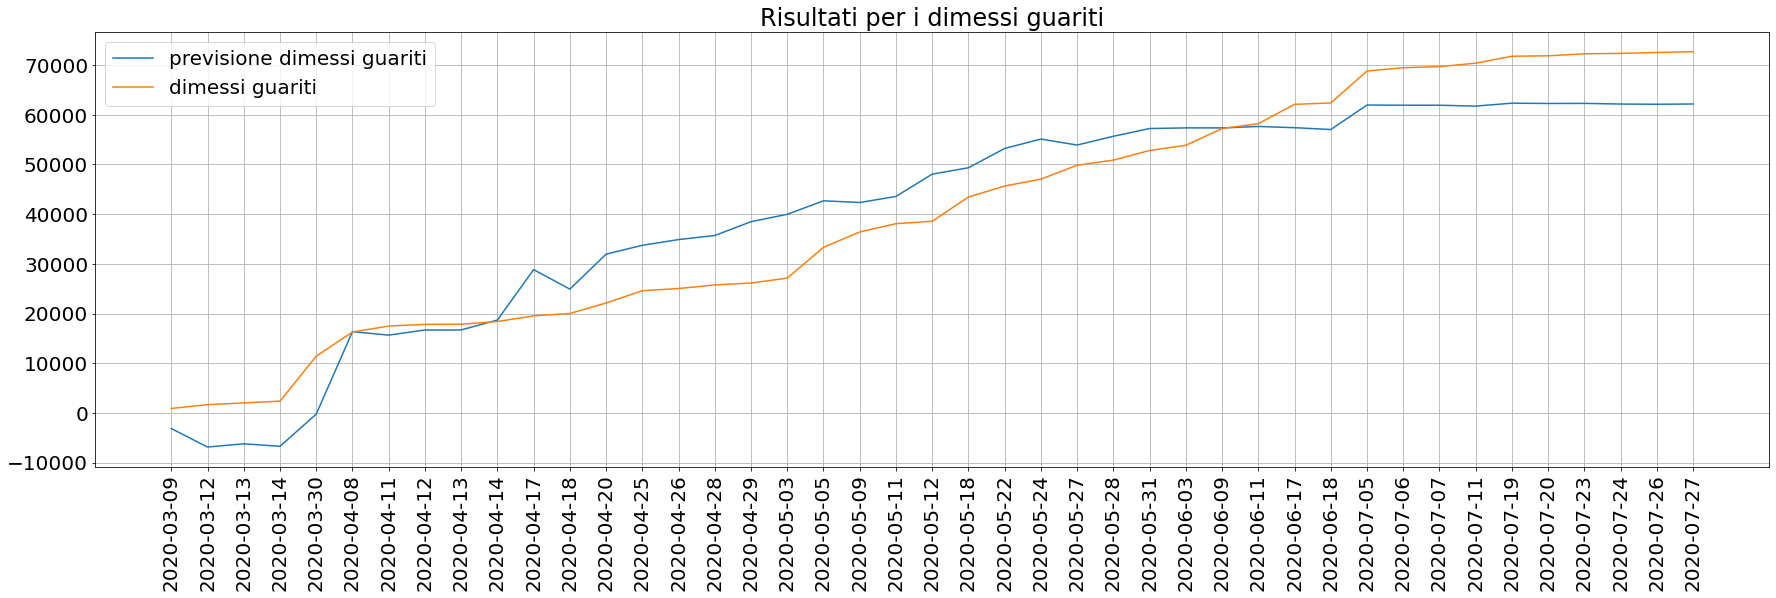




R2: 		0.891
RMSE: 		7.7e+03
MAX ERR: 	12843.502700385034


In [98]:
predicted=models[extimate_with_regression[4]].predict(x)
dataset_val=df_2.drop(train_2.index)[extimate_with_regression[4]].values


x_triks=df_2.loc[list(test_X_2.index),['Data']]
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (30, 8)
plt.plot(predicted, label="previsione dimessi guariti")
plt.plot(dataset_val, label="dimessi guariti")
plt.xticks(np.arange(x_triks.shape[0]), (x_triks['Data'].dt.date), rotation=90)
plt.legend()
plt.grid()
plt.title("Risultati per i dimessi guariti")
plt.show()
print('\n\n')
print(f"R2: \t\t{r2_score(dataset_val, predicted):.3}")
print(f"RMSE: \t\t{mean_squared_error(dataset_val, predicted, squared=False):.3}")
print(f"MAX ERR: \t{max_error(dataset_val, predicted)}")